# QiScholar - Quantum optimized journal search engine.
(Definitely better than Google Scholar)

### Installation of Necessary Libraries

In [8]:
!pip install qiskit
!pip install qiskit-aer
!pip install matplotlib
!pip install pylatexenc

### Import necessary functions, classes, and variables

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCXGate
from collections import Counter

# Import section
from qiskit_aer import AerSimulator



--- Actual coding ---

We assume that there are 500 papers in our database. Focusing only on the Quantum computing side of the system, we assume that there are 5 relevant papers from our search query (Paper #205, #107, #112, #408, #300).
### Through the oracle, these papers will be marked

In [32]:
# Number of qubits required to represent 100 papers (7 qubits)
n = 7  # 2^7 = 128 states, enough to cover 100 papers

# Create the quantum circuit
qc = QuantumCircuit(n)

# Step 1: Initialize the qubits in a superposition state
qc.h(range(n))  # Apply Hadamard gates to put all qubits in equal superposition

# Step 2: Define the Oracle (Mark multiple relevant papers)
# Assume the relevant papers are represented by binary indices: |0110011⟩, |0101010⟩, |0011100⟩,
# |1100110⟩, and |1001011⟩, corresponding to decimal values 51, 42, 28, and 102
relevant_states = ["0110011", "0101010", "0011100", "1100110"]

def apply_oracle(qc, target_states, num_qubits):
    """
    Marks multiple specific states as solutions.
    target_states: List of binary strings representing states to mark.
    num_qubits: Number of qubits in the circuit.
    """
    for state in target_states:
        # Flip qubits to match the target state
        for qubit, bit in enumerate(state):
            if bit == '0':
                qc.x(qubit)

        # Apply multi-controlled Z to mark this state
        qc.h(num_qubits - 1)  # Hadamard on the last qubit
        qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)  # Multi-controlled Z
        qc.h(num_qubits - 1)  # Uncompute Hadamard on the last qubit

        # Unflip the qubits
        for qubit, bit in enumerate(state):
            if bit == '0':
                qc.x(qubit)

# Apply the oracle to mark the relevant states
apply_oracle(qc, relevant_states, n)

### The Diffuser Operator then applies the probability of the marked stated identified by the Oracle

In [33]:
# Step 3: Diffusion Operator (Grover's Diffusion Operator)
diffusion = QuantumCircuit(n)
diffusion.h(range(n))    # Apply Hadamard to all qubits
diffusion.x(range(n))    # Apply X gates to all qubits
diffusion.h(n - 1)       # Apply Hadamard on the last qubit
diffusion.mcx(list(range(n - 1)), n - 1)  # Multi-controlled Z
diffusion.h(n - 1)       # Uncompute the Hadamard on the last qubit
diffusion.x(range(n))    # Apply X gates to all qubits
diffusion.h(range(n))    # Apply Hadamard to all qubits

# Add the diffusion operator to the main circuit
# Repeat Oracle and Diffusion approximately sqrt(128) times
num_iterations = 11  # √128 ≈ 11 for optimal probability amplification
for _ in range(num_iterations):
    apply_oracle(qc, relevant_states, n)
    qc.append(diffusion, range(n))


### After which, we measure the qubits.

###Also, we can visualize the circuit through the illustration below

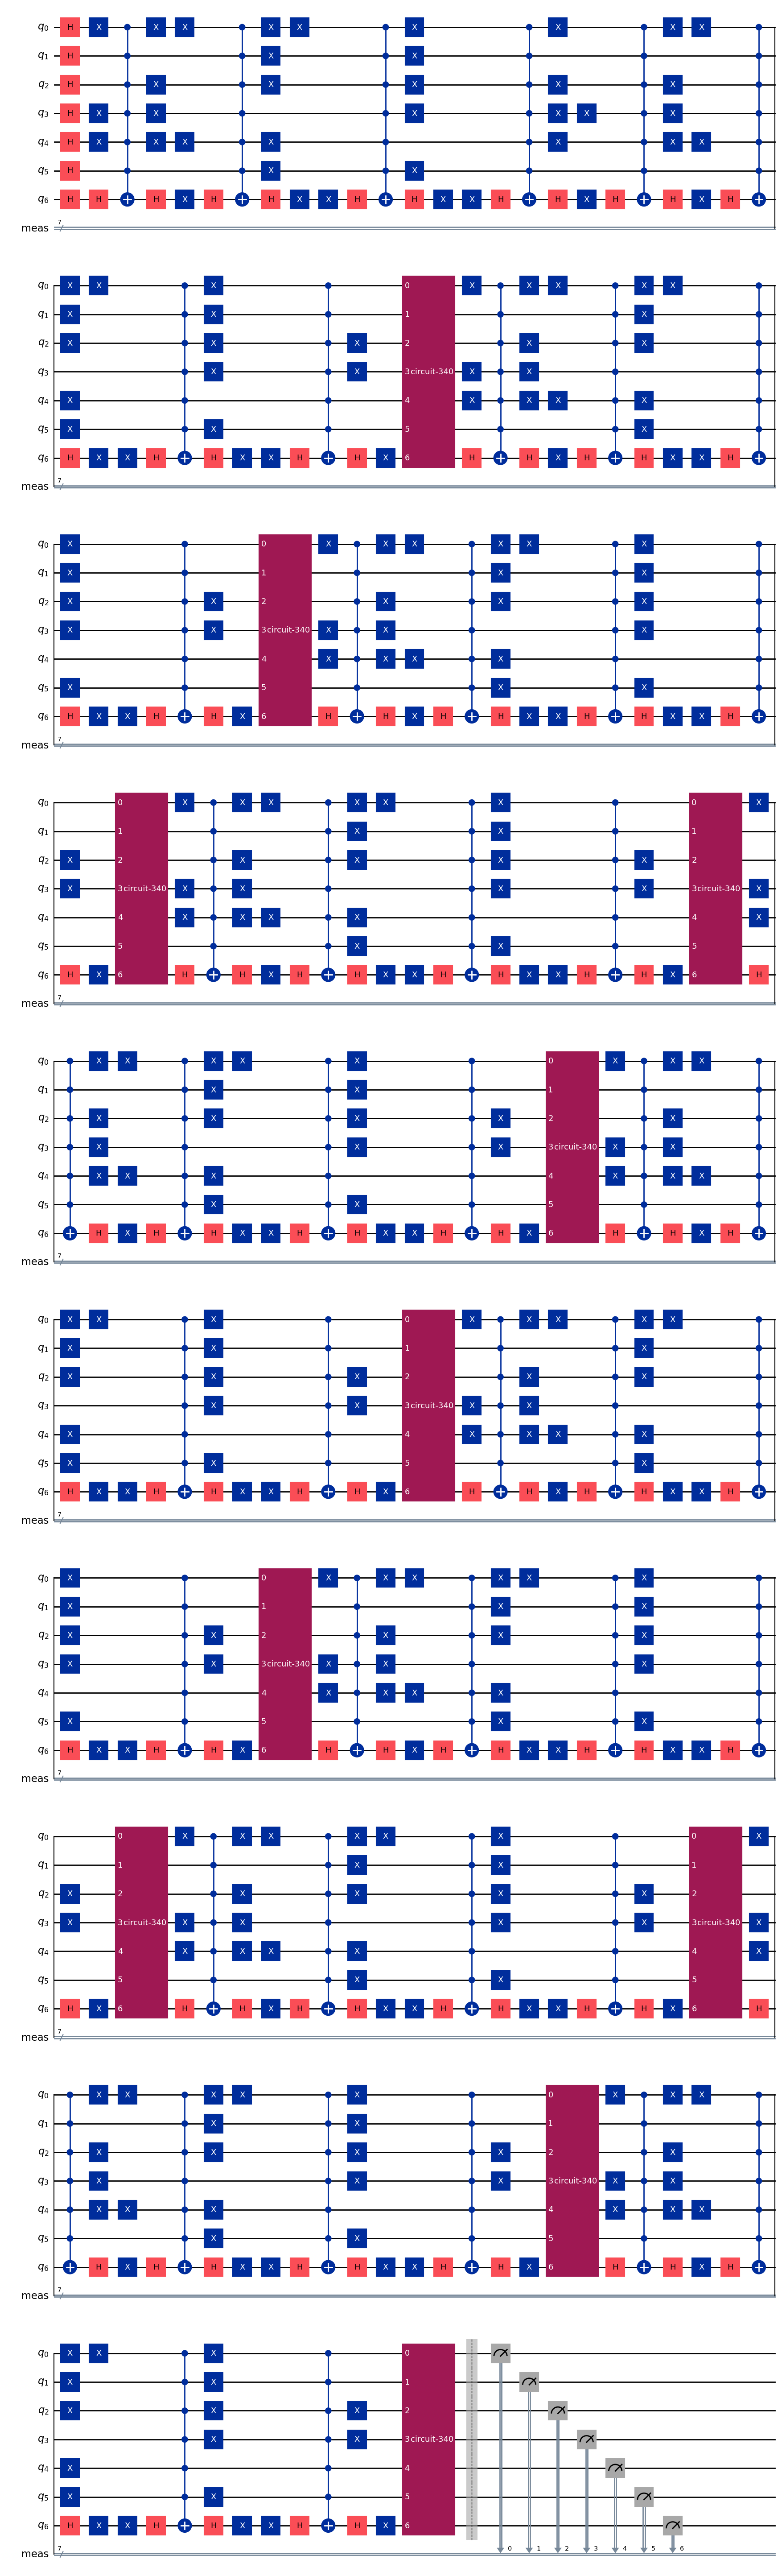

In [34]:
# Step 5: Measurement
qc.measure_all()

# Visualize the circuit using qc.draw()
qc.draw('mpl')

### We can see the graphical output of our search in the graph below

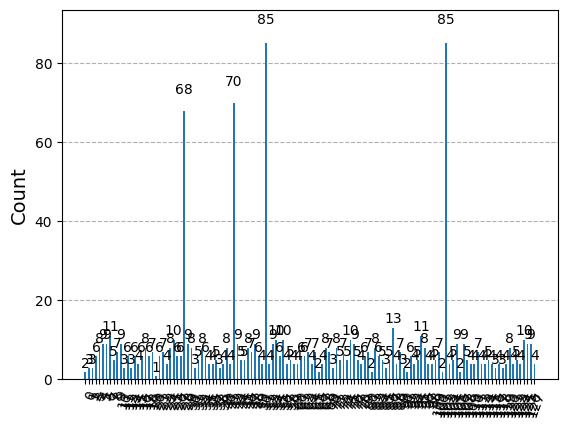

In [35]:

# Execute the circuit
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
sim_result = simulator.run(compiled_circuit).result()
counts = sim_result.get_counts()

# Process results: Convert binary states to decimal for cleaner labels
decimal_counts = {int(state, 2): count for state, count in counts.items()}

# Show the histogram with all results
plot_histogram(decimal_counts)



### Furthermore, to clean our result, we assume that our browser that only the top 5 relevant papers will be shown. The graph below shows the top 4 paper already labeled in decimal format for easy understanding of users.

Top 4 most relevant papers:
Rank 1: Paper index 102 with 85 occurrences
Rank 2: Paper index 51 with 85 occurrences
Rank 3: Paper index 42 with 70 occurrences
Rank 4: Paper index 28 with 68 occurrences


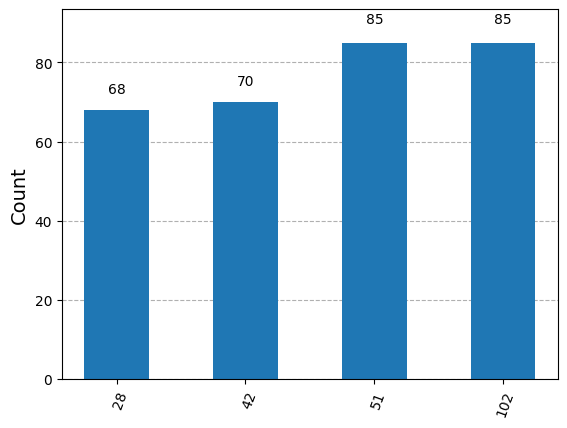

In [37]:
# Show only the top 4 results
top_4 = Counter(decimal_counts).most_common(4)
top_4_counts = dict(top_4)

# Display the top 4 results
print("Top 4 most relevant papers:")
for i, (decimal_state, count) in enumerate(top_4, start=1):
    print(f"Rank {i}: Paper index {decimal_state} with {count} occurrences")

# Plot histogram with only the top 4 results
plot_histogram(top_4_counts)